## Adventure with StarSpace: A Neural Embedding Approach

    -> StarSpace is a general-purpose neural model for efficient learning of entity embeddings for solving a wide variety of problems:

        -> Learning word, sentence or document level embeddings.
        -> Information retrieval: ranking of sets of entities/documents or objects, e.g. ranking web documents.
        -> Text classification, or any other labeling task.
        -> Metric/similarity learning, e.g. learning sentence or document similarity.
        -> Content-based or Collaborative filtering-based Recommendation, e.g. recommending music or videos.
        -> Embedding graphs, e.g. multi-relational graphs such as Freebase.
        -> Image classification, ranking or retrieval (e.g. by using existing ResNet features).

## Advanced solution: StarSpace embeddings

Now you are ready to train your own word embeddings! In particular, you need to train embeddings specially for our task of duplicates detection. Unfortunately, StarSpace cannot be run on Windows and we recommend to use provided
[docker container](https://github.com/hse-aml/natural-language-processing/blob/master/Docker-tutorial.md) or other alternatives. Don't delete results of this task because you will need it in the final project.

### How it works and what's the main difference with word2vec?
The main point in this section is that StarSpace can be trained specifically for some tasks. In contrast to word2vec model, which tries to train similar embeddings for words in similar contexts, StarSpace uses embeddings for the whole sentence (just as a sum of embeddings of words and phrases). Despite the fact that in both cases we get word embeddings as a result of the training, StarSpace embeddings are trained using some supervised data, e.g. a set of similar sentence pairs, and thus they can better suit the task.


In [36]:

import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px

In [150]:
df_train = pd.read_csv('data/drugsComTrain_raw.csv')
df_test = pd.read_csv('data/drugsComTest_raw.csv')

In [151]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [152]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [153]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']

In [154]:
df_all = df_all.dropna(axis=0)
df_all = df_all.drop_duplicates(subset=['uniqueID','review'])

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

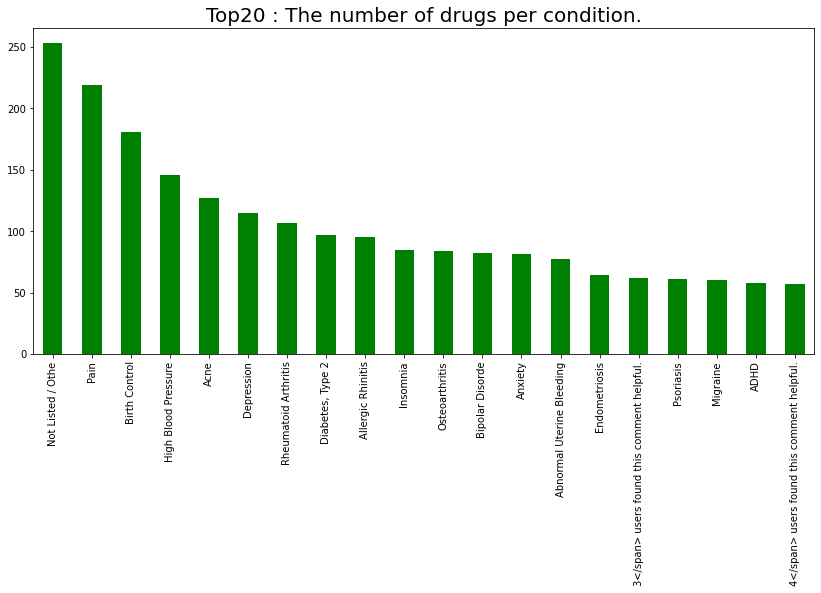

In [155]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

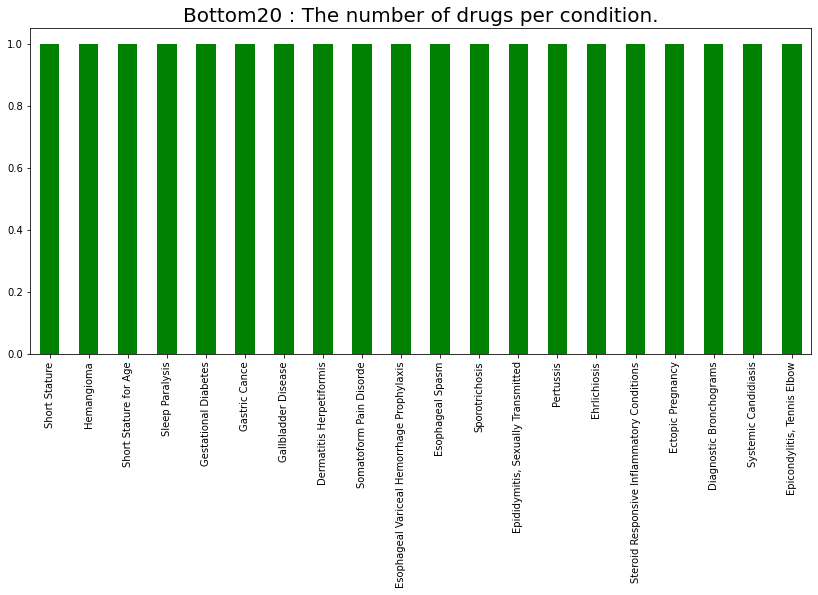

In [156]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

In [157]:
count_df = df_all[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [158]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [159]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
df_all['condition'] = df_all['condition'].apply(lambda x: condition_parser(x))

In [160]:
df_all = df_all[df_all['condition']!='OTHER']

In [161]:
px.bar(count_df[count_df['review']>3000],x='condition',y='review')

In [162]:
import contractions

In [163]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [164]:
# lower the text
df_all["review"] = df_all["review"].apply(lambda x: x.lower())

# Clean the text
df_all["review"] = df_all["review"].apply(lambda x: clean_text(x))

# Clean numbers
df_all["review"] = df_all["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df_all["review"] = df_all["review"].apply(lambda x:  " ".join([contractions.fix(word) for word in x.split()]))

In [165]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
1,95260,Guanfacine,ADHD,"""my son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""i used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""this is my first time using any form of birth...",8,3-Nov-15,10
6,165907,Levonorgestrel,Emergency Contraception,"""he pulled out, but he cummed a bit in me. i t...",1,7-Mar-17,5
7,102654,Aripiprazole,Bipolar Disorde,"""abilify changed my life. there is hope. i was...",10,14-Mar-15,32


In [196]:
f = open('data.txt','a')
for row in df_all.itertuples():
    f.write(row.review)
    f.write("\n")

In [197]:
import sentencepiece as spm

In [198]:
spm.SentencePieceTrainer.train(input='data.txt', model_prefix='m',
                               vocab_size=10000)

In [199]:
sp = spm.SentencePieceProcessor(model_file='m.model')

## Classification: Can you predict the patient's condition based on the review?

In [200]:
df_all.condition.unique()

array(['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss'], dtype=object)

In [201]:
LABELS = ['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss']

EMPTY_ID = len(LABELS)

def create_labeled_string(row):
    parts = sp.encode(row["review"], out_type = 'str')
    parts.append("__label__{}".format(row['condition']))
    return " ".join(parts)

In [202]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_all[['review','condition']],stratify=df_all['condition'], 
                                                    test_size=0.25)

In [203]:
train_lines = train.apply(create_labeled_string, 1)
with open("cache/train.txt", "w") as f:
    f.write("\n".join(train_lines))
val_lines = test.apply(create_labeled_string, axis=1)
with open("cache/val.txt", "w") as f:
    f.write("\n".join(val_lines))

In [224]:
! /Users/subir/Starspace/./starspace train -ngrams 4  -thread 4 -trainFile cache/train.txt -model cache/starspace.model

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [221]:
! /Users/subir/Starspace/./starspace test -thread 4 -testFile cache/val.txt -model cache/starspace.model -predictionFile cache/starspace.pred

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file
